# TD2C-D2C, ideas for different MBs (notebook for comparison)
This notebook wants to compare different formulations of `TD2C` method, each of them with a different way of computing the MB:

MB formulations:

1. **Past MB**: Classic TD2C's MB but considering a bigger lag in the past for the variables under exam. Ex: we want to discoveer the causal path X^(t-1)_i -> X_j and normally we would consider X_i^(t-1), X_i^(t), X_i^(t+1) and X_j^(t-1), X_j^(t), X_j^(t+1) but here we ho back in the past and try to include also  X_i^(t-2), X_i^(t-3), X_i^(t-4) and X_j^(t-2), X_j^(t-3), X_j^(t-4) in X_i and X_j's MBs. 
This is done by setting the `past_lag` parameter in the `D2C` class.

2. **TD2C-D2C MIX**: We combine TD2C's MB with a preliminary ranking of the variables as was done in D2C, trying to reduce the computational cost of D2C and maybe find a better balance for the curse of dimentionality.

3. **MBMB**: D2C's MB but enlarged, including the most relevat variables for the most relevant variables for X_i and X_j.


With this notebook you'll be able to generate the data, generate the decriptors for each of the MB formulations, obtain a classification result and plot the results for comparison.


# Settings

## Packages

In [3]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score

from d2c.data_generation.builder import TSBuilder
from d2c.descriptors_generation import D2C, DataLoader
from d2c.benchmark import D2CWrapper

## Parameters setting

In [1]:
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed for reproducibility
MB_SIZE = 2 # size to consider when estimating the markov blanket. This is only useful if the MB is actually estimated
COUPLES_TO_CONSIDER_PER_DAG = 60 # edges that are considered in total to compute descriptors, for each TS. This can speed up the process. If set to -1, all possible edges are considered
maxlags = 5 # maximum lags to consider when considering variable couples

# Data Generation
Data are generated with the `TSBuilder` class and saved in a specific folder. Then, the code checks for missing datasets in the folder and keeps running untill all the possible combinations of parameters have genereted a dataset.

In [60]:
# SET THE TSBUILDER WITH THE DESIRED PARAMETERS
def run_process(params):
    """
    Run a single process of the data generation.
    """
    process, n_variables, max_neighborhood_size, noise_std = params
    try:
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=42, 
                              max_attempts=200,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# BUILD THE DATA
if __name__ == '__main__':
    """
    This script generates the data for different parameters: processes, number of variables, neighborhood sizes and noise levels.
    The data is saved in the .data folder.
    The if __name__ == '__main__': is used to avoid multiprocessing issues in Jupyter notebooks, i.e. the script is run as a script and not
    as a module as it would have been if the script was imported, with the __name__ being the name of the module.
    If the script is imported, the __name__ is the name of the module, if it is run as a script, the __name__ is __main__.
    So, to run this script in a Jupyter notebook, we write the code inside the if __name__ == '__main__': block, while, if we want to import
    the functions from this script, we write "from script import run_process".
    """
    parameters = [(process, n_variables, max_neighborhood_size, noise_std)
                    for process in [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20] # 
                    for n_variables in [5] # , 10, 25
                    for max_neighborhood_size in [2] # , 4, 8
                    for noise_std in [0.01]] # , 0.005, 0.001

    with Pool(processes=N_JOBS) as pool:
        pool.map(run_process, parameters)


# Function to check for missing files
def check_missing_files():
    missing = []
    for process in [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]:  # 
        for n_variables in [5]:  # , 10, 25
            for max_neighborhood_size in [2]:  # , 4, 8
                for noise_std in [0.01]:  # , 0.005, 0.001
                    filename = f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'
                    if not os.path.exists(filename):
                        missing.append(filename)
    return missing

# Function to run the process
def run_process(params):
    process, n_variables, max_neighborhood_size, noise_std = params
    try:  # we change the seed and increase the max_attempts
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=24, 
                              max_attempts=400,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# CHECK FOR MISSING FILES (IT CHEKS THE FILES WITH A DIFFERENT SEED AND MORE MAX_ATTEMPTS UNTILL MISSING IS EMPTY)
if __name__ == '__main__':
    while True:
        missing = check_missing_files()
        if not missing:
            break

        parameters = []
        for missing_file in missing:
            process = int(missing_file.split('/')[-1].split('_')[0][1:])
            n_variables = int(missing_file.split('/')[-1].split('_')[1][1:])
            max_neighborhood_size = int(missing_file.split('/')[-1].split('_')[2][2:])
            noise_std = float(missing_file.split('/')[-1].split('_')[3][1:-4])
            parameters.append((process, n_variables, max_neighborhood_size, noise_std))

        with Pool(processes=N_JOBS) as pool:
            pool.map(run_process, parameters)

len(os.listdir('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data'))


KeyboardInterrupt: 

# Descriptors Generation & Classification

## Regression Estimation of MI

### D2C

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'original',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_R_rocs_process = {}
    d2c_R_precision_process = {}
    d2c_R_recall_process = {}
    d2c_R_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_R_rocs_process[gen_process_number] = rocs
        d2c_R_precision_process[gen_process_number] = precisions
        d2c_R_recall_process[gen_process_number] = recalls
        d2c_R_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_R_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/results/'

with open(os.path.join(input_folder, 'journal_results_d2c_R_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for D2C method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C

#### Descriptors Generation

In [4]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi= 'original',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/18 [00:00<?, ?it/s]

Estimating MB for nodeMarkov Blanket: 6
 Estimating MB for node[11.  1.]
 Estimating MB for node6 
1
Markov Blanket:Markov Blanket:  Estimating MB for node[6.]3Markov Blanket: Estimating MB for node 

Estimating MB for node 6[11.  1.]6
 [11.  1.] 

Markov Blanket:8
 
Estimating MB for nodeEstimating MB for node[8.] Markov Blanket: 4

[13.  3.]Markov Blanket:Markov Blanket:
  Estimating MB for node [11.  1.]Estimating MB for node[9.]
4 
Estimating MB for node
7 Markov Blanket:
1 Markov Blanket:
 Markov Blanket:[9.]Estimating MB for node [12.  2.]
 [6.]
8
Estimating MB for node
 Markov Blanket:2 
Markov Blanket:Estimating MB for node [13.  3.][7.] 

6Estimating MB for node
 1Markov Blanket:
Estimating MB for node  Markov Blanket:8[11.  1.] 

Markov Blanket:[6.] Estimating MB for node
 [13.  3.]Estimating MB for node
1 Estimating MB for node8 

4Markov Blanket:
Markov Blanket:Markov Blanket:   [13.  3.][9.][6.]

Estimating MB for node
 3
Markov Blanket: Estimating MB for node[8.]
 6
Marko

#### Run Classifier

In [40]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [39]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_R_rocs_process = {}
    td2c_R_precision_process = {}
    td2c_R_recall_process = {}
    td2c_R_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_R_rocs_process[gen_process_number] = rocs
        td2c_R_precision_process[gen_process_number] = precisions
        td2c_R_recall_process[gen_process_number] = recalls
        td2c_R_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]

ValueError: Found array with 0 sample(s) (shape=(0, 48)) while a minimum of 1 is required by BalancedRandomForestClassifier.

#### Save Results

In [17]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
    everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N10.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N25.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

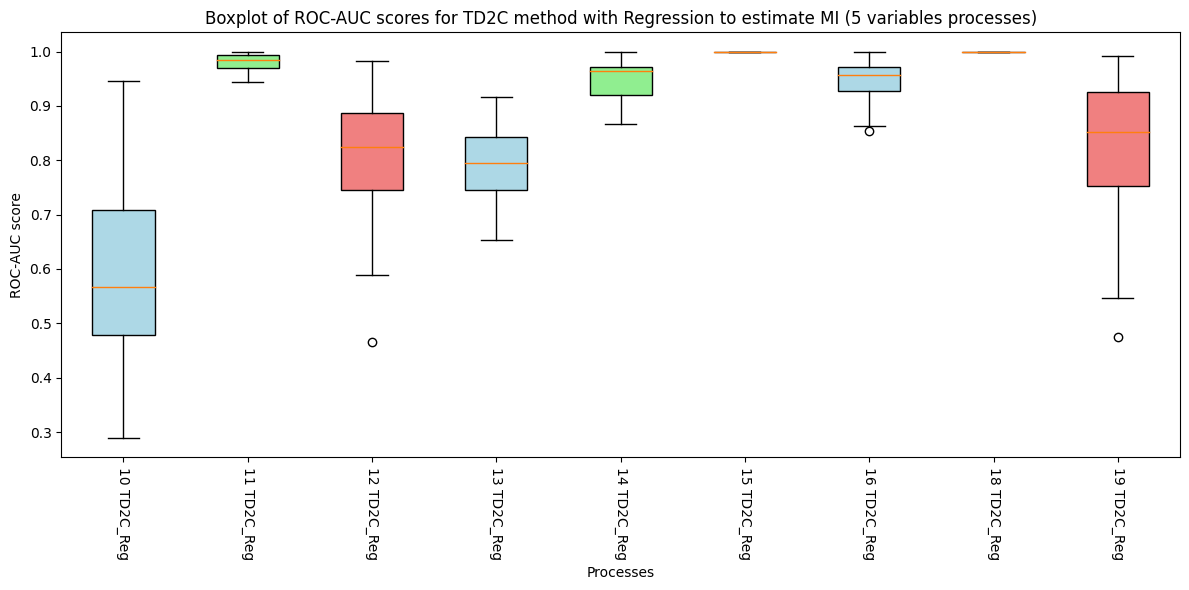

In [18]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(td2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C + Ranking

#### Descriptors Generation

In [61]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts_rank',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/18 [00:00<?, ?it/s]

Estimating MB for node 6Estimating MB for node
 Markov Blanket:6Estimating MB for node 
 Markov Blanket:6Markov Blanket:[11.  1.]
 
Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)  [11.  1.]Estimating MB for node
6
[11.  1.]
Estimating MB for node 
Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket:8 Shape of X: (245, 27), Shape of Y: (245,)
 7


Markov Blanket:Markov Blanket:[11.  1.]  
[13.  3.][12.  2.]Shape of X: (245, 27), Shape of Y: (245,)
Estimating MB for node
8
Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,) 


Markov Blanket:Estimating MB for nodeEstimating MB for node   86[13.  3.]


Markov Blanket: Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,) 
[13.  3.]Estimating MB for nodeEstimating MB for node
[11.  1.]  Shape of X: (245, 27), Shape of Y: (245,)
6
8

Shape of X: (245, 27), Shape of Y: (245,) Markov Blanket:Estimating MB for node
Markov Blanket:  6[11.  1.][13.  3.]


Shape of X: (245, 27), Shape of Y: (

  6%|▌         | 1/18 [00:12<03:25, 12.09s/it]

Estimating MB for node Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node6  
  66Estimating MB for node6
8
Estimating MB for nodeMarkov Blanket:Estimating MB for node 
Markov Blanket:
Markov Blanket:7   Markov Blanket:Estimating MB for node Markov Blanket: 68
Estimating MB for nodeEstimating MB for node[11.  1.] 
   Markov Blanket:
 
86Markov Blanket: Shape of X: (245, 27), Shape of Y: (245,) [11.  1.][13.  3.][12.  2.]
Estimating MB for node Estimating MB for nodeMarkov Blanket:
Markov Blanket:

  [11.  1.] Estimating MB for node86Estimating MB for nodeMarkov Blanket: [13.  3.]
Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)  
[11.  1.]
Markov Blanket:Estimating MB for node
8
[11.  1.]
 [11.  1.]


Shape of X: (245, 27), Shape of Y: (245,) 
[13.  3.]Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)8Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)


 11%|█         | 2/18 [01:11<10:37, 39.82s/it]

Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node    Estimating MB for node111111Estimating MB for node10 Estimating MB for node



 11 Estimating MB for nodeMarkov Blanket:Markov Blanket:Markov Blanket:5
10Markov Blanket:  Estimating MB for node  
Markov Blanket: 
11Estimating MB for node Estimating MB for nodeMarkov Blanket: [15.  5.][16.  6.]7Markov Blanket:[16.  6.][16.  6.]   [16.  6.]
Estimating MB for node


 

7
12 Markov Blanket:[10.  0.]Estimating MB for node[15.  5.]
Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node Shape of X: (245, 27), Shape of Y: (245,)11
Shape of X: (245, 27), Shape of Y: (245,) Shape of X: (245, 27), Shape of Y: (245,)

 
 


Markov Blanket:
10[16.  6.]Markov Blanket:
Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)7Estimating MB for node[12.  2.] 

 Markov Blanket:


 
Markov Blanket: [17.  7.]Shape of X: (245,

 17%|█▋        | 3/18 [02:16<12:51, 51.42s/it]

Estimating MB for nodeEstimating MB for node Estimating MB for node 11Estimating MB for node11 
 Estimating MB for node
11Markov Blanket:10 Estimating MB for nodeMarkov Blanket:
 
11 Markov Blanket: Estimating MB for node
Markov Blanket:[16.  6.]Estimating MB for node5   
 Estimating MB for nodeMarkov Blanket:
Estimating MB for node[16.  6.]11[16.  6.][15.  5.]10 Estimating MB for node Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket: 




[16.  6.]7  12
Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket:
Estimating MB for node7

Estimating MB for node [10.  0.]


 
 Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)Markov Blanket:Markov Blanket:
 [16.  6.]Estimating MB for node[15.  5.]11
  Markov Blanket: Shape of X: (245, 27), Shape of Y: (245,)10
 

7 [12.  2.]
[17.  7.]Shape of X: (245, 27), Shape of Y: (245,)
Shape of X: (245, 27), Shape of Y: (245,)Estimating

 22%|██▏       | 4/18 [03:20<13:10, 56.43s/it]

Estimating MB for nodeEstimating MB for node  Estimating MB for node66
 
Markov Blanket:6Markov Blanket:Estimating MB for nodeEstimating MB for nodeEstimating MB for node 
    8Markov Blanket:[11.  1.]Estimating MB for node6Estimating MB for node7Estimating MB for node[11.  1.]
  
 

 
Markov Blanket:88Estimating MB for nodeMarkov Blanket:[11.  1.]Shape of X: (245, 27), Shape of Y: (245,)6Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket: 

  
Estimating MB for node

Estimating MB for node
 Estimating MB for nodeMarkov Blanket:Markov Blanket:[13.  3.]8[12.  2.]Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket:  [11.  1.]  

 

 Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node
668[13.  3.]Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,)[11.  1.]
Estimating MB for node[13.  3.] Shape of X: (245, 27), Shape of Y: (245,)



Estimating MB for node 

 Markov Blanket:
 8
Markov Blanket:Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)Markov Bla

 28%|██▊       | 5/18 [04:14<12:03, 55.67s/it]

Estimating MB for node 6
Markov Blanket:Estimating MB for nodeEstimating MB for node   66Estimating MB for node8 6 
Shape of X: (245, 27), Shape of Y: (245,)
[11.  1.]
Estimating MB for node
Markov Blanket:
 Markov Blanket: 
Markov Blanket:[11.  1.]Markov Blanket: [11.  1.] 
[13.  3.]
[11.  1.]Shape of X: (245, 27), Shape of Y: (245,)

Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)
Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)
 

7
Estimating MB for nodeMarkov Blanket:  8Estimating MB for node
[12.  2.] Markov Blanket:6
 Estimating MB for node
Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)[13.  3.]Markov Blanket:  

 88Shape of X: (245, 27), Shape of Y: (245,)


Markov Blanket:[11.  1.]Markov Blanket: 
 [13.  3.]Shape of X: (245, 27), Shape of Y: (245,)

[13.  3.]Shape of X: (245, 27), Shape of Y: (245,)
Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node
 
6
Estimating MB for nodeEstimating MB for nodeM

 33%|███▎      | 6/18 [05:13<11:18, 56.50s/it]

Estimating MB for nodeEstimating MB for node Estimating MB for node 6Estimating MB for nodeEstimating MB for node
6  Markov Blanket:Estimating MB for node 
78 6
 
Markov Blanket:
[11.  1.]Markov Blanket:6 Markov Blanket:
Markov Blanket: 
 Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node Estimating MB for node
Markov Blanket:8
[11.  1.][11.  1.]6[13.  3.]
[11.  1.]Markov Blanket:
[12.  2.]
[11.  1.]



Shape of X: (245, 27), Shape of Y: (245,)

Estimating MB for node   
Markov Blanket:

 Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,) Shape of X: (245, 27), Shape of Y: (245,)[13.  3.]
Shape of X: (245, 27), Shape of Y: (245,) Shape of X: (245, 27), Shape of Y: (245,)
8
Estimating MB for node
 Markov Blanket:8 
Markov Blanket:[13.  3.] 
Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)[13.  3.] 

6Shape of X: (245, 27), Shape of Y: (245,)
Estimating MB for node
Markov Blanket:  6[11. 

 39%|███▉      | 7/18 [06:11<10:29, 57.21s/it]

Estimating MB for node 6
Markov Blanket: [11.  1.]
Estimating MB for nodeEstimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)
Estimating MB for node   668


Markov Blanket:Markov Blanket: Markov Blanket:  Estimating MB for node Estimating MB for node[11.  1.][13.  3.][11.  1.]6 



7Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)
 

 
Markov Blanket:8[11.  1.] 

Estimating MB for nodeMarkov Blanket:[12.  2.]Shape of X: (245, 27), Shape of Y: (245,) 
 
[13.  3.]Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node8


Shape of X: (245, 27), Shape of Y: (245,) 
Markov Blanket:6
 Estimating MB for nodeMarkov Blanket: Estimating MB for node[13.  3.] 6[11.  1.]
 

Estimating MB for nodeMarkov Blanket:Shape of X: (245, 27), Shape of Y: (245,)8 Shape of X: (245, 27), Shape of Y: (245,) 
1


Markov Blanket:Markov Blanket:[11.  1.]  
[6.]
Shape of X: (245, 27), Sh

 44%|████▍     | 8/18 [06:29<07:26, 44.67s/it]

Estimating MB for nodeEstimating MB for node  Estimating MB for node1111Estimating MB for nodeEstimating MB for node 
 
11 Estimating MB for nodeMarkov Blanket:1211
Estimating MB for nodeMarkov Blanket:  Estimating MB for node
 
Markov Blanket: 12 [16.  6.]11Markov Blanket: Markov Blanket:
Estimating MB for node[16.  6.]19
 
 Estimating MB for nodeMarkov Blanket:

[16.  6.] Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node[16.  6.] Markov Blanket:
[17.  7.] Markov Blanket:
Shape of X: (245, 27), Shape of Y: (245,)15 17
Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node
 
 [17.  7.]11

Shape of X: (245, 27), Shape of Y: (245,)
Shape of X: (245, 27), Shape of Y: (245,)[16.  6.] Markov Blanket:Estimating MB for node
[24. 14.]
Markov Blanket:

Estimating MB for node
17  Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,) 

 Shape of X: (245, 27), Shape of Y: (245,)12 [20. 10.]
[22. 12.]12Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,)


Estimating M

 50%|█████     | 9/18 [07:35<07:40, 51.21s/it]

Estimating MB for node 11
Markov Blanket: Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node[16.  6.]    
   11Estimating MB for node10Estimating MB for node111011Shape of X: (245, 27), Shape of Y: (245,)
Estimating MB for node115 

 
Estimating MB for nodeMarkov Blanket:


7
 Markov Blanket:Markov Blanket: Markov Blanket:Markov Blanket:7Markov Blanket:
12 Markov Blanket:  Estimating MB for node
   Markov Blanket:
11Estimating MB for node  [16.  6.]Markov Blanket:[15.  5.][15.  5.] Markov Blanket:
Estimating MB for node10 
 
[16.  6.]
Estimating MB for node Markov Blanket:
7[16.  6.] [12.  2.][12.  2.][10.  0.]
[16.  6.][17.  7.]Shape of X: (245, 27), Shape of Y: (245,)  Markov Blanket:
Shape of X: (245, 27), Shape of Y: (245,)
Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node

Estimating MB for node
1014
[16.  6.]Shape of X: (245, 27), Shape of Y: (245,)Estimating MB f

 56%|█████▌    | 10/18 [08:41<07:27, 55.99s/it]

Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node Estimating MB for node   Estimating MB for node    21 20Estimating MB for node22 22
2424Estimating MB for node22
 
2222

Markov Blanket:20

 Markov Blanket:Markov Blanket:Estimating MB for node
Estimating MB for nodeMarkov Blanket:

Markov Blanket:Markov Blanket:Markov Blanket:22 24  Markov Blanket:  Markov Blanket:  Markov Blanket: 
 
Estimating MB for node22[26. 16.] Estimating MB for node22 [27. 17.] [25. 15.]Markov Blanket:Markov Blanket:[27. 17.][29. 19.]


[29. 19.] [27. 17.] [27. 17.]
[27. 17.]
[25. 15.] Estimating MB for node 


Markov Blanket:22



Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)[27. 17.]Estimating MB for nodeEstimating MB for node24 [29. 19.]Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (24

 61%|██████    | 11/18 [09:33<06:21, 54.56s/it]

Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node          15Estimating MB for nodeEstimating MB for node11191711111211
1112
 

 


Markov Blanket:

Estimating MB for node
Markov Blanket:17Markov Blanket:Markov Blanket:11Markov Blanket:Markov Blanket:Markov Blanket:Markov Blanket: Markov Blanket:Estimating MB for node 
 
Markov Blanket:  Estimating MB for node    [20. 10.] Markov Blanket:12Markov Blanket:  [16.  6.][22. 12.][24. 14.]
 Estimating MB for node[16.  6.][16.  6.][16.  6.][16.  6.][17.  7.] 
 

11[17.  7.]
Estimating MB for node12Shape of X: (245, 27), Shape of Y: (245,)
Estimating MB for node


 Markov Blanket:

[16.  6.][22. 12.]Shape of X: (245, 27), Shape of Y: (245,)
Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)
Shape of X: (245, 27), Shape of Y: (245,)
 Shape of X:

 67%|██████▋   | 12/18 [10:39<05:48, 58.01s/it]

Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node    1111Estimating MB for node1111


 
Estimating MB for nodeMarkov Blanket:12Markov Blanket:Markov Blanket:Markov Blanket:  
 Estimating MB for node[16.  6.] 12Markov Blanket: [16.  6.]
 [16.  6.] [16.  6.]
Estimating MB for node11Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for nodeMarkov Blanket:[17.  7.]
 

 Estimating MB for node 


Shape of X: (245, 27), Shape of Y: (245,)19Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node15 Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket:


[17.  7.]

 17 
Markov Blanket:
Markov Blanket:11
Estimating MB for nodeEstimating MB for node
 [16.  6.]Shape of X: (245, 27), Shape of Y: (245,) Markov Blanket:  Markov Blanket:
[20. 10.][24. 14.]
Estimating MB for node17 12 

Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node

 [22. 12.][16.  6.]Markov Blanket:Markov Blanket:
Shape of 

 72%|███████▏  | 13/18 [11:44<05:01, 60.27s/it]

Estimating MB for node 11Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node  
  Estimating MB for node1011Markov Blanket:1111Estimating MB for node 


 
5 Markov Blanket:Markov Blanket:Markov Blanket:Estimating MB for node[16.  6.]Markov Blanket:
 10   
Markov Blanket: 
Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)11 Markov Blanket:[16.  6.][16.  6.][15.  5.][16.  6.]Estimating MB for node

  [10.  0.]7 



Markov Blanket:
Estimating MB for node[15.  5.]
12Shape of X: (245, 27), Shape of Y: (245,) Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)
Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,) Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket:



Shape of X: (245, 27), Shape of Y: (245,) [16.  6.]7

Markov Blanket: 
Estimating MB for node
11
 [12.  2.]Estimating MB for nodeShape of X: (245, 27), Shape of Y: (245,)
Markov Blanket: [17.  7.]
10  

Markov Blanket:Estimating MB fo

 78%|███████▊  | 14/18 [12:50<04:08, 62.06s/it]

Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node   Estimating MB for nodeEstimating MB for node 181718
  18

Estimating MB for nodeMarkov Blanket:Markov Blanket:Estimating MB for node
Markov Blanket: 75Estimating MB for node
    
6Markov Blanket: Markov Blanket:Estimating MB for node[22. 12.]15
 Markov Blanket: 5
Estimating MB for node
Estimating MB for nodeMarkov Blanket: 
 Shape of X: (245, 27), Shape of Y: (245,)[23. 13.] Markov Blanket: 17 [23. 13.][12.  2.][23. 13.]Estimating MB for nodeMarkov Blanket:Estimating MB for node
[10.  0.] 5
Estimating MB for node17

 
 
[20. 10.]

[11.  1.]Markov Blanket:  
Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)7Shape of X: (245, 27), Shape of Y: (245,)7

Markov Blanket:Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,) Shape of X: (245, 27), Shape of Y: (245,)17Estimating MB for node

[10.  0.]Estimating MB for node


Shape of X: (245, 27), Shape of Y: (245,)Shap

 83%|████████▎ | 15/18 [14:26<03:36, 72.09s/it]

Estimating MB for node 11Estimating MB for node
Markov Blanket:  Estimating MB for node11[16.  6.]

 Markov Blanket:Shape of X: (245, 27), Shape of Y: (245,)11 

Estimating MB for nodeMarkov Blanket:[16.  6.]  
[16.  6.]Shape of X: (245, 27), Shape of Y: (245,)11
Estimating MB for node

Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket:
  12[16.  6.]

Estimating MB for nodeMarkov Blanket:Shape of X: (245, 27), Shape of Y: (245,) 
 [17.  7.]12
Estimating MB for node
Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket: 
 15
[17.  7.]Markov Blanket:Estimating MB for node
 Shape of X: (245, 27), Shape of Y: (245,) 
[20. 10.]19Estimating MB for node

Estimating MB for node Shape of X: (245, 27), Shape of Y: (245,)Markov Blanket:17  

15[24. 14.]Markov Blanket:
 
Estimating MB for nodeEstimating MB for nodeMarkov Blanket:Shape of X: (245, 27), Shape of Y: (245,)[22. 12.]  
 1Estimating MB for node
11

Shape of X: (245, 27), Shape of Y: (245,) [20. 10.]Markov Blanket:Markov Blanket:

 89%|████████▉ | 16/18 [15:31<02:20, 70.08s/it]

Estimating MB for node 18
Markov Blanket: [23. 13.]Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node
Estimating MB for nodeEstimating MB for nodeEstimating MB for node Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for nodeEstimating MB for nodeEstimating MB for node7   
 Estimating MB for node
  156   518Markov Blanket:1817
 
57
17
 

Markov Blanket:Markov Blanket:8


Markov Blanket:Estimating MB for nodeMarkov Blanket:Markov Blanket:  Markov Blanket:[12.  2.]
Estimating MB for nodeMarkov Blanket:Markov Blanket: Markov Blanket:    
 Markov Blanket:   Estimating MB for node7Shape of X: (245, 27), Shape of Y: (245,) 7[10.  0.]
 

[12.  2.][22. 12.]
17Estimating MB for node[23. 13.][13.  3.][10.  0.][23. 13.][22. 12.]Markov Blanket:[20. 10.]Markov Blanket:[11.  1.]


Shape of X: (245, 27), Shape of Y: (245,)


 

 Markov Blanket:
Shape of X: (245, 27), Shape of Y: (245,)
 Shape of X: (245, 27), Shape of Y: (245,)
Shape of X: (245, 27), Shape

 94%|█████████▍| 17/18 [16:36<01:08, 68.64s/it]

Estimating MB for node 11
Markov Blanket: Estimating MB for nodeEstimating MB for nodeEstimating MB for node[16.  6.]Estimating MB for node
 Estimating MB for node  11Shape of X: (245, 27), Shape of Y: (245,) 10
 
115
Markov Blanket:11
Estimating MB for node
 Markov Blanket:
Markov Blanket:  Markov Blanket:Markov Blanket:10   
[16.  6.][15.  5.]Estimating MB for nodeMarkov Blanket:[16.  6.][16.  6.]

[10.  0.] Estimating MB for node 


[15.  5.]7 

Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)11Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)Shape of X: (245, 27), Shape of Y: (245,)

Markov Blanket:

Estimating MB for node


 Markov Blanket:  [12.  2.]12

[16.  6.]Shape of X: (245, 27), Shape of Y: (245,)
Markov Blanket:
 Shape of X: (245, 27), Shape of Y: (245,)Estimating MB for node[17.  7.]
Estimating MB for node 
11Shape of X: (245, 27), Shape of Y: (245,) 

7Markov Blank

100%|██████████| 18/18 [17:41<00:00, 58.97s/it]


#### Run Classifier

In [62]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [63]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rank_R_rocs_process = {}
    td2c_rank_R_precision_process = {}
    td2c_rank_R_recall_process = {}
    td2c_rank_R_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rank_R_rocs_process[gen_process_number] = rocs
        td2c_rank_R_precision_process[gen_process_number] = precisions
        td2c_rank_R_recall_process[gen_process_number] = recalls
        td2c_rank_R_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/my

#### Save Results

In [64]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_rank_R_N5.pkl'), 'wb') as f:
    everything = (td2c_rank_R_rocs_process, td2c_rank_R_precision_process, td2c_rank_R_recall_process, td2c_rank_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

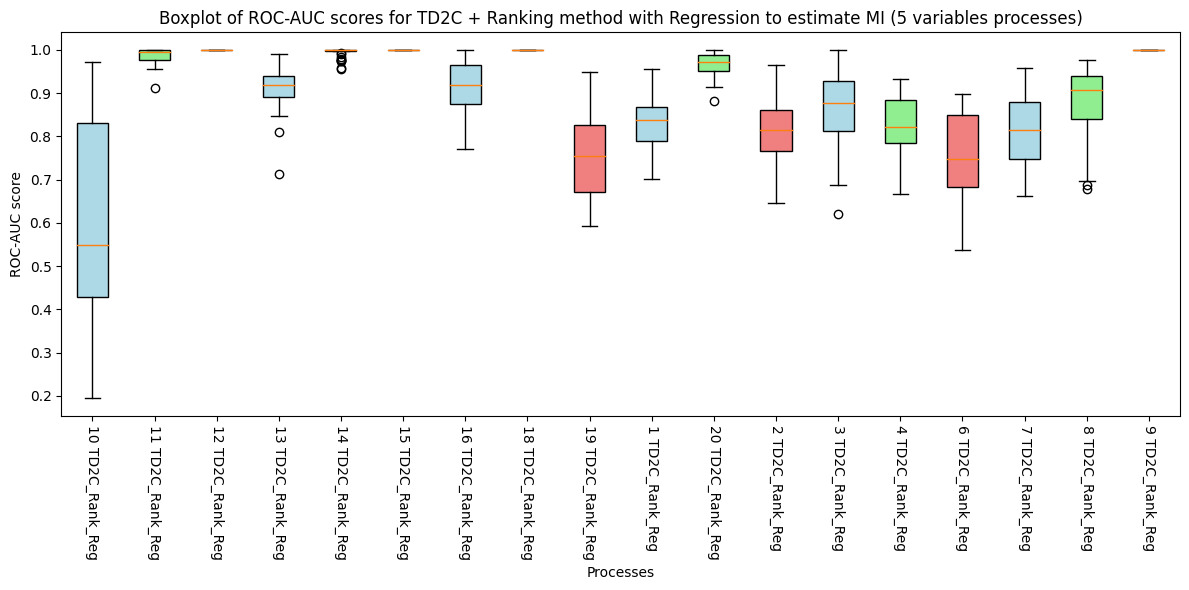

In [65]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_rank_R_N5.pkl'), 'rb') as f:
    td2_rank_R_rocs_process, td2c_rank_R_precision_process, td2c_rank_R_recall_process, td2c_rank_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(td2c_rank_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Rank_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C + Ranking method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C in the past (for X_i^(t-n), with n > 1)

#### Descriptors Generation

In [66]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_Past/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts_past')

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/18 [00:00<?, ?it/s]

Estimating MB for node 6Estimating MB for node
 Markov Blanket:6 
[11.  1.]Markov Blanket:Estimating MB for node
 Estimating MB for node  [11.  1.]61


Estimating MB for nodeMarkov Blanket: Markov Blanket: 3Estimating MB for node 
[11.  1.] 
Markov Blanket:[6.]8Estimating MB for node 

[8.] Estimating MB for nodeEstimating MB for node4
Markov Blanket:  
 7Markov Blanket:6 

[13.  3.][9.]Estimating MB for node
Markov Blanket:Markov Blanket:
  Estimating MB for node 8 
[12.  2.]4[11.  1.]Markov Blanket:
 

Estimating MB for nodeEstimating MB for nodeMarkov Blanket:[13.  3.]Estimating MB for node   
 6Estimating MB for node2
1[9.] 
Markov Blanket:1

 Markov Blanket:
 [11.  1.]Markov Blanket:
[7.]Markov Blanket: Estimating MB for node 
[6.] 1

Markov Blanket:[6.] [6.]

Estimating MB for node 8
Markov Blanket: [13.  3.]
Estimating MB for node 48Estimating MB for node
 Markov Blanket:Estimating MB for node  [9.]
6
Estimating MB for nodeMarkov Blanket:
  Markov Blanket:6 
[13.  3.][11.  1.]Ma

  6%|▌         | 1/18 [00:09<02:42,  9.57s/it]

Estimating MB for node Estimating MB for node66 
Estimating MB for nodeMarkov Blanket:
 Markov Blanket:  6[11.  1.]
[11.  1.]
Markov Blanket:
Estimating MB for nodeEstimating MB for node Estimating MB for node  8Estimating MB for node1 [11.  1.]
3

 Estimating MB for nodeEstimating MB for node
Markov Blanket:Markov Blanket:6   Markov Blanket: 
47Estimating MB for node [6.]Markov Blanket:

[13.  3.][8.] 
 Markov Blanket:Markov Blanket:Estimating MB for node

Estimating MB for node  
 
[11.  1.]8[9.][12.  2.] 6Markov Blanket: Estimating MB for nodeEstimating MB for node


4  Estimating MB for node
Markov Blanket:8
Estimating MB for node Markov Blanket:[13.  3.] 1 2 
Markov Blanket:
[11.  1.]8
Estimating MB for nodeMarkov Blanket:[9.] Estimating MB for node

Markov Blanket:
   [13.  3.]Estimating MB for nodeEstimating MB for node Markov Blanket:61[6.] [7.]


6
  
Markov Blanket:Estimating MB for node
Markov Blanket:1Estimating MB for node Estimating MB for nodeMarkov Blanket:[13.  3.] 
  

 11%|█         | 2/18 [01:07<10:06, 37.92s/it]

Estimating MB for node 11
Markov Blanket: [16.  6.]
Estimating MB for node 1
Markov Blanket: [6.]
Estimating MB for nodeEstimating MB for nodeEstimating MB for node    111011Estimating MB for node


Markov Blanket: Markov Blanket:Estimating MB for node11Markov Blanket: 
  Markov Blanket:5
 [16.  6.]Markov Blanket:[16.  6.][15.  5.][16.  6.]
 Estimating MB for node


Estimating MB for node[10.  0.]Estimating MB for nodeEstimating MB for node Estimating MB for node 
  1 Estimating MB for node1011
 0

Markov Blanket:
0
Markov Blanket: Markov Blanket:Markov Blanket:
Markov Blanket: [6.]  Markov Blanket: [6.]
Estimating MB for node [6.]
Estimating MB for node[5.][15.  5.] 
[5.] 

117


Estimating MB for nodeMarkov Blanket:Markov Blanket:   0
[12.  2.][16.  6.]
Markov Blanket:
Estimating MB for nodeEstimating MB for nodeEstimating MB for node    121[5.]2


Markov Blanket:
Markov Blanket:  Markov Blanket:[6.] 
[17.  7.][7.]

Estimating MB for nodeEstimating MB for nodeEstimating MB for node  

 17%|█▋        | 3/18 [02:06<11:53, 47.60s/it]

Estimating MB for node  11
Markov Blanket:[16.  6.]Estimating MB for node
Estimating MB for node  [6.] 111

Markov Blanket:Markov Blanket: [16.  6.]

Estimating MB for nodeEstimating MB for node 1 
Markov Blanket:11 
[6.]
Markov Blanket: [16.  6.]
Estimating MB for node 1
Markov Blanket: 
[6.]Estimating MB for nodeEstimating MB for nodeEstimating MB for node  10 5 
Estimating MB for node11
Markov Blanket:  
Markov Blanket:10Markov Blanket:[15.  5.]

 Estimating MB for nodeEstimating MB for nodeMarkov Blanket:  [10.  0.] 110[16.  6.]



Markov Blanket:Markov Blanket:Estimating MB for node[15.  5.] Estimating MB for node  
[5.] [16.  6.]01

Estimating MB for node
Estimating MB for node 
 Markov Blanket:01 Estimating MB for node

Markov Blanket:Estimating MB for nodeMarkov Blanket:[5.]Markov Blanket:    
 [6.]7[6.]12[5.]




Markov Blanket:Markov Blanket:  [12.  2.][17.  7.]

Estimating MB for nodeEstimating MB for nodeEstimating MB for node   272


Markov Blanket:Markov Blanket:Estimatin

 22%|██▏       | 4/18 [02:20<08:01, 34.39s/it]

Estimating MB for node Estimating MB for nodeEstimating MB for nodeEstimating MB for node 6 6
 6Estimating MB for node
8 Markov Blanket:
Estimating MB for nodeEstimating MB for nodeMarkov Blanket:
 6 Markov Blanket: Markov Blanket:
  [11.  1.]87 Estimating MB for nodeMarkov Blanket:
Estimating MB for node
Estimating MB for node  
[11.  1.][11.  1.][13.  3.]Estimating MB for node Markov Blanket: 6

[11.  1.]Markov Blanket: 
8 8
Estimating MB for nodeEstimating MB for nodeEstimating MB for node1Estimating MB for node

 [12.  2.]Estimating MB for nodeMarkov Blanket:
   
 Estimating MB for nodeEstimating MB for nodeMarkov Blanket:
[13.  3.]  Markov Blanket:464 Markov Blanket:  3Estimating MB for node
6 

[11.  1.] 8
 
[13.  3.]1Estimating MB for node
Markov Blanket:Markov Blanket:Estimating MB for node
[13.  3.]
[6.]Markov Blanket:2
 
Markov Blanket:Markov Blanket:  Estimating MB for node  Markov Blanket:Estimating MB for node
1

 Markov Blanket:Estimating MB for node [9.] [9.] [11.  1.]8 

 28%|██▊       | 5/18 [03:17<09:14, 42.63s/it]

Estimating MB for nodeEstimating MB for node 6 Estimating MB for node
6 
Markov Blanket:6 Markov Blanket:
 Markov Blanket:[11.  1.] 
[11.  1.]Estimating MB for node[11.  1.]
 
Estimating MB for node1Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node 
Estimating MB for node   Markov Blanket:3  748 

68

[6.]Markov Blanket:Estimating MB for nodeMarkov Blanket:Markov Blanket:
Markov Blanket:
 
  Estimating MB for nodeMarkov Blanket: [8.]Markov Blanket: 6Estimating MB for node 
[9.] [13.  3.] 
[12.  2.]
[11.  1.]8
 
Markov Blanket:[13.  3.]
8Estimating MB for nodeEstimating MB for node
Estimating MB for node
 Markov Blanket: 
4 Estimating MB for node Estimating MB for nodeEstimating MB for node Markov Blanket:2 6   Markov Blanket:
11
Markov Blanket:[13.  3.]


 6
 Estimating MB for node
[13.  3.][11.  1.]Markov Blanket:
8Estimating MB for nodeEstimating MB for nodeEstimating MB for node 
Markov Blanket:Markov Blanket:Markov Blanket:[9.]
    [7.]  Marko

 33%|███▎      | 6/18 [04:13<09:26, 47.18s/it]

Estimating MB for node 6
Markov Blanket: Estimating MB for node[11.  1.] 6

Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeMarkov Blanket:  1  
68Markov Blanket:
[11.  1.]
 Markov Blanket:
 Markov Blanket:Estimating MB for node[6.]  
Estimating MB for node[11.  1.]3

 [13.  3.]Estimating MB for nodeEstimating MB for nodeMarkov Blanket:6
   
4Estimating MB for node[8.]Markov Blanket:7

  
Markov Blanket:4 [11.  1.]Markov Blanket:
[9.] 
Markov Blanket:
Estimating MB for node  [12.  2.]1[9.]

Markov Blanket:
Estimating MB for nodeEstimating MB for nodeEstimating MB for node    [6.]6
82


Markov Blanket: Markov Blanket:Markov Blanket:[11.  1.]  
[7.]Estimating MB for node[13.  3.]
 
1Estimating MB for node
 Estimating MB for nodeMarkov Blanket:Estimating MB for node1   
88[6.]
Markov Blanket:
Markov Blanket:
Markov Blanket:   Estimating MB for node[6.][13.  3.] [13.  3.]

6
Estimating MB for node
Estimating MB for node Markov Blanket: 3 4

Markov Blanket:Markov Blanket: 

 39%|███▉      | 7/18 [04:26<06:34, 35.86s/it]

Estimating MB for node Estimating MB for node 6Estimating MB for node6

 Markov Blanket:Markov Blanket: 6 [11.  1.]Estimating MB for node
[11.  1.]Markov Blanket:Estimating MB for node 

 Estimating MB for node
8 Estimating MB for nodeEstimating MB for node6   [11.  1.]Estimating MB for node
Markov Blanket:7
13  Markov Blanket:

Markov Blanket:Estimating MB for node
 8[13.  3.]Estimating MB for nodeMarkov Blanket: Markov Blanket:
 [11.  1.]
  4 Markov Blanket:Estimating MB for node
Estimating MB for node[12.  2.]6
[8.]Estimating MB for node [6.]
Estimating MB for node 
 Markov Blanket: 

Estimating MB for node [13.  3.]Markov Blanket:8 41 8Estimating MB for node 

[9.]


 2Markov Blanket:[11.  1.]
Markov Blanket:Estimating MB for nodeMarkov Blanket:Estimating MB for nodeMarkov Blanket:6
 
    Markov Blanket:
 Estimating MB for nodeEstimating MB for node[9.]16  [6.]Markov Blanket:Estimating MB for node
 8

[7.]
  [13.  3.][13.  3.]
1Estimating MB for nodeMarkov Blanket:
Markov Blanket:8

 44%|████▍     | 8/18 [05:21<06:59, 41.90s/it]

Estimating MB for node 11
Markov Blanket: [16.  6.]
Estimating MB for node 1
Markov Blanket:Estimating MB for nodeEstimating MB for node Estimating MB for nodeEstimating MB for nodeEstimating MB for node[6.]
     11121211
11


Markov Blanket:
 Markov Blanket:Markov Blanket:Markov Blanket:Estimating MB for nodeEstimating MB for nodeMarkov Blanket:      1911

[16.  6.]Markov Blanket:[17.  7.][16.  6.][17.  7.][16.  6.]Markov Blanket:
 


 
Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node[24. 14.] Estimating MB for node[16.  6.]    
 
1211521Estimating MB for nodeEstimating MB for node




 
Markov Blanket: Estimating MB for nodeMarkov Blanket:Markov Blanket:1Markov Blanket:Markov Blanket: Markov Blanket: 2
   17  
[6.]Markov Blanket:[7.]
[6.][7.] 
Markov Blanket:
Markov Blanket:
[6.]
[20. 10.][6.]  


[22. 12.][7.]
Estimating MB for node
Estimating MB for node  20

Markov Blanket: Markov Blanket:[7.] Estimating MB for node
[5.

 50%|█████     | 9/18 [06:20<07:06, 47.37s/it]

Estimating MB for node 11
Markov Blanket:Estimating MB for node  [16.  6.]11

Estimating MB for nodeMarkov Blanket:  1
[16.  6.]Markov Blanket:
 Estimating MB for nodeEstimating MB for node[6.]  
111

Markov Blanket:Markov Blanket:  [6.][16.  6.]

Estimating MB for node 1
Markov Blanket: [6.]
Estimating MB for nodeEstimating MB for nodeEstimating MB for node   105
11


Markov Blanket:Estimating MB for nodeMarkov Blanket: Markov Blanket:  10 Markov Blanket:[10.  0.] 
[15.  5.]Estimating MB for node
Estimating MB for node Estimating MB for node 0Estimating MB for node11 
 
07Markov Blanket:Markov Blanket:

  Markov Blanket:Markov Blanket:[5.]  
[5.]
[15.  5.][16.  6.]

Estimating MB for node Estimating MB for node[12.  2.][16.  6.]0
 

Estimating MB for node1 Markov Blanket:Estimating MB for nodeEstimating MB for node
2  
 Markov Blanket:[5.]112
Markov Blanket: 

 Markov Blanket:[6.]Markov Blanket:[7.]  

[6.][17.  7.]Estimating MB for node

 Estimating MB for node 72

Markov Blanket:Mar

 56%|█████▌    | 10/18 [07:17<06:41, 50.20s/it]

Estimating MB for node 21
Markov Blanket: [26. 16.]Estimating MB for node
Estimating MB for nodeEstimating MB for nodeEstimating MB for node   22 2022
4

Markov Blanket:
Markov Blanket: Markov Blanket: Markov Blanket:  [27. 17.][9.][27. 17.][25. 15.]Estimating MB for node



Estimating MB for node Estimating MB for node Estimating MB for node242  

22Markov Blanket:Markov Blanket:

  Estimating MB for nodeMarkov Blanket:Markov Blanket:[7.][29. 19.] 
  
Estimating MB for node[7.]24[7.] 


4Markov Blanket:Estimating MB for node
  Markov Blanket:20Estimating MB for node 
[29. 19.] [9.]Markov Blanket:
22
 Estimating MB for node
 Markov Blanket:[25. 15.] 4
Estimating MB for node
Estimating MB for node[27. 17.] Markov Blanket: 
2 22
Estimating MB for node[9.] 
Markov Blanket:2
Markov Blanket:Estimating MB for node 
[7.] Markov Blanket: 
 22[7.][27. 17.]


Markov Blanket:Estimating MB for nodeEstimating MB for node   022[27. 17.]


Markov Blanket:Markov Blanket:Estimating MB for node Estimati

 61%|██████    | 11/18 [07:32<04:36, 39.49s/it]

Estimating MB for nodeEstimating MB for node  1111
Estimating MB for node
Markov Blanket: Markov Blanket: 11 [16.  6.]
[16.  6.]
Estimating MB for nodeEstimating MB for nodeMarkov Blanket:
Estimating MB for node  Estimating MB for nodeEstimating MB for node  12 1
[16.  6.] 111
Markov Blanket:Estimating MB for node12Estimating MB for node


Markov Blanket:  Estimating MB for nodeMarkov Blanket:
 Markov Blanket: Estimating MB for node
11 19 [17.  7.] Markov Blanket: [6.]

[6.][16.  6.]1Estimating MB for node 15
Markov Blanket:Markov Blanket:
Estimating MB for node
 

  Estimating MB for node Estimating MB for nodeMarkov Blanket:17Markov Blanket:[24. 14.] [17.  7.]2  
[16.  6.] 

111Markov Blanket:
[6.]
Estimating MB for node[20. 10.]Estimating MB for nodeMarkov Blanket:
 

Estimating MB for nodeEstimating MB for node 
  Markov Blanket:[22. 12.] Markov Blanket: Estimating MB for node2Estimating MB for node17[7.] 
1
2   
Estimating MB for node
[16.  6.]
Markov Blanket:12
0[6.]Estimating MB

 67%|██████▋   | 12/18 [08:31<04:33, 45.54s/it]

Estimating MB for nodeEstimating MB for nodeEstimating MB for node   11Estimating MB for node1111 


11Markov Blanket:Estimating MB for nodeMarkov Blanket:
Markov Blanket:   Markov Blanket: [16.  6.]12 [16.  6.]

[16.  6.][16.  6.]
Estimating MB for node
Markov Blanket:
Estimating MB for nodeEstimating MB for node Estimating MB for node Estimating MB for nodeEstimating MB for node  1  [17.  7.]1 121Estimating MB for node11

1


 
Markov Blanket:Estimating MB for nodeMarkov Blanket:
Markov Blanket:Markov Blanket:19 Markov Blanket:Estimating MB for node  
  Markov Blanket: [6.] 2Markov Blanket:[6.][6.]
[16.  6.]Estimating MB for node15  


[17.  7.]

 [24. 14.][6.]Markov Blanket:Estimating MB for nodeMarkov Blanket:Estimating MB for node

17 
 Estimating MB for node Estimating MB for node Estimating MB for node1[7.]
  11[20. 10.] 

Markov Blanket:2

217Estimating MB for nodeMarkov Blanket: 
Markov Blanket:
 Estimating MB for node
Markov Blanket:  [22. 12.]Markov Blanket: 12Markov Blanket

 72%|███████▏  | 13/18 [09:30<04:08, 49.66s/it]

Estimating MB for node 11Estimating MB for node
 Markov Blanket:Estimating MB for node11  
[16.  6.]Markov Blanket:11
 
Estimating MB for nodeMarkov Blanket:[16.  6.]  
Estimating MB for node1[16.  6.] Estimating MB for nodeEstimating MB for nodeEstimating MB for node

1Estimating MB for node   Estimating MB for nodeMarkov Blanket:
51011   Markov Blanket:Estimating MB for node


 [6.]110Markov Blanket: Markov Blanket:[6.]Markov Blanket:

 11Estimating MB for node
 
 Markov Blanket:
[10.  0.]Markov Blanket: [15.  5.] Estimating MB for nodeMarkov Blanket:[16.  6.] 
7
 [6.]
 
Estimating MB for node[15.  5.]Estimating MB for nodeEstimating MB for node12Estimating MB for node [16.  6.]
Markov Blanket:
 
  0
Estimating MB for node Estimating MB for node01Markov Blanket:7
Estimating MB for node Estimating MB for node 

  0Estimating MB for nodeMarkov Blanket:
 Markov Blanket:11Markov Blanket:1
 [12.  2.]
  10[17.  7.]Markov Blanket:Markov Blanket: 

[5.]Markov Blanket:

[6.]  [5.]Markov Blank

 78%|███████▊  | 14/18 [10:30<03:30, 52.53s/it]

Estimating MB for node 17
Markov Blanket: Estimating MB for node[22. 12.]
 Estimating MB for node18 
1Markov Blanket:
 Markov Blanket: [6.]Estimating MB for node
[23. 13.] 
Estimating MB for node18 
4Markov Blanket:
Markov Blanket:  [9.][23. 13.]

Estimating MB for node 1
Markov Blanket: [6.]
Estimating MB for nodeEstimating MB for node 7 
18Markov Blanket:
 Estimating MB for nodeMarkov Blanket: [12.  2.] 
 5Estimating MB for node
 [23. 13.]Markov Blanket:2

Markov Blanket:[10.  0.]Estimating MB for node 
 [7.]Estimating MB for node1
 Estimating MB for node
0 Markov Blanket:
6 Markov Blanket:
 [6.]Markov Blanket:[5.]
 
Estimating MB for node 5[11.  1.]

Estimating MB for nodeMarkov Blanket:Estimating MB for node  2 
15[10.  0.]Markov Blanket:

 Markov Blanket:Estimating MB for node[7.]  
0[20. 10.]

Markov Blanket:Estimating MB for node  [5.]0

Markov Blanket: [5.]Estimating MB for node
 17
Markov Blanket: [22. 12.]
Estimating MB for node Estimating MB for node2 
17Markov Blanket: 
[7.

 83%|████████▎ | 15/18 [11:26<02:41, 53.78s/it]

Estimating MB for node 11
Markov Blanket: [16.  6.]
Estimating MB for node 1Estimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for nodeEstimating MB for node
  Markov Blanket:    1115 1211
1112

[6.]

Markov Blanket:
Markov Blanket:Markov Blanket:
 Estimating MB for nodeMarkov Blanket:Markov Blanket:Markov Blanket:      [16.  6.][20. 10.]19[17.  7.][16.  6.]

[17.  7.]

Estimating MB for node[16.  6.]
Markov Blanket:
Estimating MB for node 
Estimating MB for nodeEstimating MB for node  Estimating MB for node1Estimating MB for node  Estimating MB for node0[24. 14.]Estimating MB for node
  21 

 2Markov Blanket:
15
Estimating MB for node1
Markov Blanket:17 
Markov Blanket: Markov Blanket:
Markov Blanket: 
Markov Blanket:2[6.]   Markov Blanket:
Markov Blanket:[7.] 
Estimating MB for node [6.][5.][7.]Markov Blanket:
  [20. 10.]
[6.] 

11
[22. 12.]
[7.]
Estimating MB for node
Estimating MB for node
Markov Blanket:  Estimating MB for node 17

 89%|████████▉ | 16/18 [12:21<01:48, 54.11s/it]

Estimating MB for node 18
Markov Blanket: [23. 13.]
Estimating MB for node 4
Markov Blanket:Estimating MB for node [9.] 
7
Markov Blanket: Estimating MB for node[12.  2.] 
18Estimating MB for node
 Markov Blanket:4
 Markov Blanket: [23. 13.][9.]

Estimating MB for node 1
Estimating MB for nodeMarkov Blanket:  [6.]Estimating MB for node
18 7

Markov Blanket:Markov Blanket:  [12.  2.]
[23. 13.]Estimating MB for nodeEstimating MB for nodeMarkov Blanket:Markov Blanket:   
25

Estimating MB for node  [7.]1[10.  0.]


Markov Blanket:Estimating MB for node  0[6.]Estimating MB for node

Markov Blanket:  6[5.]

Markov Blanket: 
Estimating MB for node[11.  1.] 5
Estimating MB for nodeMarkov Blanket: Estimating MB for node  215[10.  0.]


Markov Blanket:Markov Blanket:Estimating MB for node  
 Estimating MB for node[7.]0 
[20. 10.]Markov Blanket:
17Estimating MB for nodeEstimating MB for node 
 [5.] 17
Markov Blanket:0

Estimating MB for node Markov Blanket:Markov Blanket:   8[22. 12.][5.]
[22. 1

 94%|█████████▍| 17/18 [12:46<00:45, 45.21s/it]

Estimating MB for node Estimating MB for nodeEstimating MB for node 11 Estimating MB for node11
Estimating MB for node11 Estimating MB for node Markov Blanket:
 
10 11Markov Blanket:5

Markov Blanket:Estimating MB for nodeEstimating MB for node[16.  6.] 
Markov Blanket:Markov Blanket:
   Markov Blanket:  11Estimating MB for node[16.  6.]10Estimating MB for node[16.  6.] [15.  5.]
[16.  6.]

Estimating MB for node  

Markov Blanket:Estimating MB for node[10.  0.]Estimating MB for node
Markov Blanket: 1Estimating MB for node7   Estimating MB for nodeEstimating MB for node
 12
 
1Estimating MB for nodeEstimating MB for node7[16.  6.]  Markov Blanket:Estimating MB for node
[15.  5.]1
Markov Blanket:
0
  1  
Markov Blanket:Markov Blanket: 
Markov Blanket:Estimating MB for node
Estimating MB for node[6.]
100  Markov Blanket:11Estimating MB for node[12.  2.]Markov Blanket: Estimating MB for node Estimating MB for node
Markov Blanket: 

[17.  7.] [6.] 

 [12.  2.] 7 1 Markov Blanket:Markov Bla

100%|██████████| 18/18 [13:44<00:00, 45.83s/it]


#### Run Classifier

In [67]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_Past/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [68]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_past_R_rocs_process = {}
    td2c_past_R_precision_process = {}
    td2c_past_R_recall_process = {}
    td2c_past_R_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_past_R_rocs_process[gen_process_number] = rocs
        td2c_past_R_precision_process[gen_process_number] = precisions
        td2c_past_R_recall_process[gen_process_number] = recalls
        td2c_past_R_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/my

#### Save Results

In [69]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_past_R_N5.pkl'), 'wb') as f:
    everything = (td2c_past_R_rocs_process, td2c_past_R_precision_process, td2c_past_R_recall_process, td2c_past_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

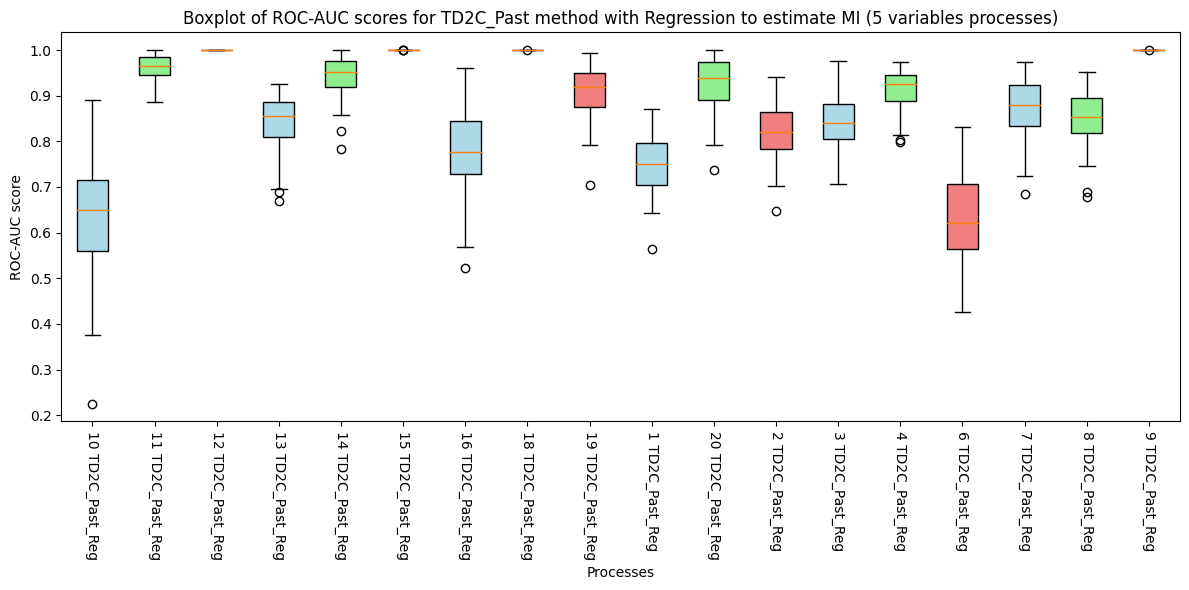

In [70]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_R_N5.pkl'), 'rb') as f:
    td2c_past_R_rocs_process, td2c_past_R_precision_process, td2c_past_R_recall_process, td2c_past_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(td2c_past_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Past_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_Past method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

## KNNCMI Estimation of MI

### D2C

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/D2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'original')

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_K_rocs_process = {}
    d2c_K_precision_process = {}
    d2c_K_recall_process = {}
    d2c_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_K_rocs_process[gen_process_number] = rocs
        d2c_K_precision_process[gen_process_number] = precisions
        d2c_K_recall_process[gen_process_number] = recalls
        d2c_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_R_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_past method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_K_rocs_process = {}
    td2c_K_precision_process = {}
    td2c_K_recall_process = {}
    td2c_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_K_rocs_process[gen_process_number] = rocs
        td2c_K_precision_process[gen_process_number] = precisions
        td2c_K_recall_process[gen_process_number] = recalls
        td2c_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_K_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C + Ranking

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'ts_rank',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run CLassifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rank_K_rocs_process = {}
    td2c_rank_K_precision_process = {}
    td2c_rank_K_recall_process = {}
    td2c_rank_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rank_K_rocs_process[gen_process_number] = rocs
        td2c_rank_K_precision_process[gen_process_number] = precisions
        td2c_rank_K_recall_process[gen_process_number] = recalls
        td2c_rank_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_rank_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_rank_K_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_rank method with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C in the past (for X_i^(t-n), with n > 1)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_Past/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn',
            mb_estimator= 'ts_rank',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_Past/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_past_K_rocs_process = {}
    td2c_past_K_precision_process = {}
    td2c_past_K_recall_process = {}
    td2c_past_K_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_past_K_rocs_process[gen_process_number] = rocs
        td2c_past_K_precision_process[gen_process_number] = precisions
        td2c_past_K_recall_process[gen_process_number] = recalls
        td2c_past_K_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/results/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_past_K_N5.pkl'), 'wb') as f:
    everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_K_N5.pkl'), 'rb') as f:
    d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(d2c_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores fro TD2C_past method with knnCMI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

# Plot all Results - Comparison

### ROC-AUC

#### Regression

In [73]:
# df1 = pd.DataFrame(d2c_R_rocs_process)
df2 = pd.DataFrame(td2c_R_rocs_process)
df3 = pd.DataFrame(td2c_rank_R_rocs_process)
df4 = pd.DataFrame(td2c_past_R_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    # combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    # labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Rank')
    labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots ROC-AUC scores for TD2C, TD2C+Rank and TD2C_Past methods with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

KeyError: 10

#### knnCMI

In [ ]:
import matplotlib.pyplot as plt

df1 = pd.DataFrame(d2c_K_rocs_process)
df2 = pd.DataFrame(td2c_K_rocs_process)
df3 = pd.DataFrame(td2c_rank_K_rocs_process)
# df4 = pd.DataFrame(td2c_past_K_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for ROC-AUC scores for D2C, TD2C and TD2C+Ranking methods with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

### Precision

#### Regression

In [ ]:
df1 = pd.DataFrame(d2c_R_precision_process)
df2 = pd.DataFrame(td2c_R_precision_process)
df3 = pd.DataFrame(td2c_rank_R_precision_process)
# df4 = pd.DataFrame(td2c_past_R_precision_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Precision scores for D2C, TD2C and TD2C+Ranking methods with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

#### knnCMI

In [ ]:
df1 = pd.DataFrame(d2c_K_precision_process)
df2 = pd.DataFrame(td2c_K_precision_process)
df3 = pd.DataFrame(td2c_rank_K_precision_process)
# df4 = pd.DataFrame(td2c_past_K_precision_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Precision scores for D2C, TD2C and TD2C+Ranking methods with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

### Recall

#### Regression

In [ ]:
df1 = pd.DataFrame(d2c_R_recall_process)
df2 = pd.DataFrame(td2c_R_recall_process)
df3 = pd.DataFrame(td2c_rank_R_recall_process)
# df4 = pd.DataFrame(td2c_past_K_precision_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Two DataFrames')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

#### knnCMI

In [ ]:
df1 = pd.DataFrame(d2c_K_recall_process)
df2 = pd.DataFrame(td2c_K_recall_process)
df3 = pd.DataFrame(td2c_rank_K_recall_process)
# df4 = pd.DataFrame(td2c_past_K_precision_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Two DataFrames')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

### F1

#### Regression

In [ ]:
df1 = pd.DataFrame(d2c_R_f1_process)
df2 = pd.DataFrame(td2c_R_f1_process)
df3 = pd.DataFrame(td2c_rank_R_f1_process)
# df4 = pd.DataFrame(td2c_past_R_f1_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for F1 scores for D2C, TD2C and TD2C+Ranking methods with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

#### knnCMI

In [ ]:
df1 = pd.DataFrame(d2c_K_f1_process)
df2 = pd.DataFrame(td2c_K_f1_process)
df3 = pd.DataFrame(td2c_rank_K_f1_process)
# df4 = pd.DataFrame(td2c_past_K_f1_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    # combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C')
    labels.append(f'{col} TD2C')
    labels.append(f'{col} TD2C+Ranking')
    # labels.append(f'{col} TD2C+Past')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for F1 scores for D2C, TD2C and TD2C+Ranking methods with knnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()